In [1]:
# %% [markdown]
# # TFMS Stock Prediction - Model Training (Final Fixed Version)

# %%
# Cell 1: Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create results directories
os.makedirs("../data/results/models", exist_ok=True)
os.makedirs("../data/results/metrics", exist_ok=True)


In [2]:
# %%
# Cell 2: Data Preparation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler



def load_prepare_data(ticker):
    df = pd.read_csv(f"../data/processed/integrated/{ticker}_integrated.csv", parse_dates=['Date'])
    df = df.dropna()
    
    technical_features = ['RSI_14', 'SMA_20', 'Volume']
    fundamental_features = ['debt_to_equity', 'sentiment_3day_ma']
    lookback = 60  # 60 timesteps
    n_features = len(technical_features)  # Should be 3
    
    # Calculate maximum complete sequences
    n_samples = (len(df) - lookback + 1)
    
    # Create properly shaped technical data
    X_tech = np.zeros((n_samples, lookback, n_features))
    y = np.zeros(n_samples)
    
    for i in range(n_samples):
        X_tech[i] = df[technical_features].iloc[i:i+lookback].values
        y[i] = df['target_5day_return'].iloc[i+lookback-1]
    
    # Get aligned fundamental data
    X_fund = df[fundamental_features].iloc[lookback-1:lookback-1+n_samples].values
    
    # Split data (80/20)
    split_idx = int(0.8 * n_samples)
    
    # Scale technical features
    scaler = StandardScaler()
    X_tech_scaled = scaler.fit_transform(
        X_tech.reshape(-1, n_features)
    ).reshape(X_tech.shape)
    
    return {
        'X_tech_train': X_tech_scaled[:split_idx],
        'X_tech_test': X_tech_scaled[split_idx:],
        'X_fund_train': X_fund[:split_idx],
        'X_fund_test': X_fund[split_idx:],
        'y_train': y[:split_idx],
        'y_test': y[split_idx:],
        'features': {
            'technical': technical_features,
            'fundamental': fundamental_features
        },
        'scalers': {
            'tech_scaler': scaler
        }
    }

In [3]:
# %%
# Cell 3: Fixed Keras Regressor Wrapper

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import model_from_json
import json

# Updated KerasRegressorWrapper
from tensorflow.keras.models import save_model, load_model
import tempfile
import os

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_builder, input_shape, epochs=30):
        self.model_builder = model_builder
        self.input_shape = input_shape
        self.epochs = epochs
        self._model = None
        self._temp_model_file = None
        
    def fit(self, X, y):
        # Extract technical features (first lookback*n_features columns)
        n_features = self.input_shape[-1]
        lookback = self.input_shape[0]
        tech_features = lookback * n_features
        X_tech = X[:, :tech_features]
        
        # Reshape for LSTM
        X_reshaped = X_tech.reshape(-1, lookback, n_features)
        
        # Build and train model
        self._model = self.model_builder(self.input_shape)
        self._model.compile(optimizer='adam', loss='mse')
        self._model.fit(X_reshaped, y, epochs=self.epochs, verbose=0)
        return self
        
    def predict(self, X):
        # Extract technical features
        n_features = self.input_shape[-1]
        lookback = self.input_shape[0]
        tech_features = lookback * n_features
        X_tech = X[:, :tech_features]
        
        # Reshape and predict
        X_reshaped = X_tech.reshape(-1, lookback, n_features)
        return self._model.predict(X_reshaped).flatten()
    
    def __getstate__(self):
        # Custom serialization to handle Keras model
        state = self.__dict__.copy()
        if self._model is not None:
            # Save model to temporary file
            fd, path = tempfile.mkstemp(suffix='.h5')
            try:
                os.close(fd)
                save_model(self._model, path)
                with open(path, 'rb') as f:
                    state['_model_data'] = f.read()
            finally:
                os.remove(path)
            del state['_model']
        return state
    
    def __setstate__(self, state):
        # Custom deserialization
        if '_model_data' in state:
            # Restore model from temporary file data
            fd, path = tempfile.mkstemp(suffix='.h5')
            try:
                os.close(fd)
                with open(path, 'wb') as f:
                    f.write(state['_model_data'])
                state['_model'] = load_model(path)
                del state['_model_data']
            finally:
                os.remove(path)
        self.__dict__.update(state)





def train_ensemble(models, X_train, y_train, ticker):
    lookback = 60
    n_features = 3
    
    # Technical features should already be properly shaped
    X_tech = X_train['technical']
    n_samples = X_tech.shape[0]
    
    # Flatten technical features for stacking
    X_tech_flat = X_tech.reshape(n_samples, -1)  # Shape: (n_samples, lookback*n_features)
    
    # Align fundamental features
    X_fund = X_train['fundamental'][:n_samples]  # Ensure same number of samples
    y_aligned = y_train[:n_samples]
    
    # Combine features - now only using the correct number of technical features
    tech_feature_cols = lookback * n_features
    X_combined = np.hstack([X_tech_flat[:, :tech_feature_cols], X_fund])
    
    print(f"Final feature matrix shape: {X_combined.shape}")
    print(f"Target shape: {y_aligned.shape}")
    
    # Create Keras wrapper with persistent model builder
    keras_reg = KerasRegressorWrapper(
        model_builder=build_technical_model,
        input_shape=(lookback, n_features),
        epochs=30
    )
    
    # Create ensemble
    ensemble = StackingRegressor(
        estimators=[
            ('technical', keras_reg),
            ('fundamental', clone(models['fundamental']))
        ],
        final_estimator=RandomForestRegressor(n_estimators=50),
        cv=3,
        n_jobs=1
    )
    
    ensemble.fit(X_combined, y_aligned)
    return ensemble

In [4]:
# %%
# Cell 4: Model Training Functions
def build_technical_model(input_shape):
    """Model builder function that returns a fresh compiled model"""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64,
             activation='tanh',
             recurrent_activation='sigmoid',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_constraint=MaxNorm(3),
             recurrent_constraint=MaxNorm(3)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_technical_model(X_train, y_train, X_test, y_test):
    """Train LSTM model with proper initialization and gradient control"""
    # Normalize targets
    y_mean, y_std = y_train.mean(), y_train.std()
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std
    
    # Build and compile model
    model = build_technical_model((X_train.shape[1], X_train.shape[2]))
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
        loss='mse',
        metrics=['mae']
    )
    
    # Train with callbacks
    history = model.fit(
        X_train, y_train_norm,
        validation_data=(X_test, y_test_norm),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )
    
    # Store normalization parameters
    model.y_mean = y_mean
    model.y_std = y_std
    
    return model

def train_fundamental_model(X_train, y_train):
    """XGBoost model for fundamentals"""
    model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        objective='reg:squarederror'
    )
    model.fit(X_train, y_train)
    return model


def prepare_technical_features(X_tech, lookback=60, n_features=3):
    """Ensure data can be reshaped by trimming excess elements"""
    elements_per_sample = lookback * n_features  # 180
    total_elements = (X_tech.size // elements_per_sample) * elements_per_sample
    
    # Trim to largest whole number of samples
    X_trimmed = X_tech[:total_elements]
    
    # Reshape
    n_samples = total_elements // elements_per_sample
    X_reshaped = X_trimmed.reshape(n_samples, lookback, n_features)
    X_flat = X_reshaped.reshape(n_samples, -1)  # Flatten for stacking
    
    print(f"Trimmed {X_tech.size - total_elements} elements")
    print(f"Final shape: {X_reshaped.shape}")
    return X_reshaped, X_flat






In [5]:
# %% [markdown]
# ## Main Execution (Complete)

# %%
# Configuration
ticker = 'XOM'
print(f"Starting training pipeline for {ticker}...\n")

# 1. Load and prepare data
print("Loading and preparing data...")
data = load_prepare_data(ticker)
print(f"Data loaded successfully with {len(data['X_tech_train'])} training samples\n")

data = load_prepare_data(ticker)
print("X_tech_train shape:", data['X_tech_train'].shape)
print("X_fund_train shape:", data['X_fund_train'].shape)
print("y_train shape:", data['y_train'].shape)

print("X_tech_train samples:", data['X_tech_train'].shape[0])
print("X_fund_train samples:", data['X_fund_train'].shape[0])
print("y_train samples:", data['y_train'].shape[0])

# # Debug prints
# print(f"Raw technical data shape: {X_train['technical'].shape}")
# print(f"Fundamental data shape: {X_train['fundamental'].shape}")
# print(f"Target shape: {y_train.shape}")

# # Sample calculation
# n_samples = X_train['technical'].shape[0] // (60 * 3)
# print(f"Can create {n_samples} complete sequences")

# 2. Train models
print("Training technical model (LSTM)...")
tech_model = train_technical_model(
    data['X_tech_train'],
    data['y_train'],      # Using the correct key
    data['X_tech_test'],
    data['y_test']
)
tech_model.save(f"../data/results/models/{ticker}_lstm.keras")
print("Technical model trained and saved\n")

print("Training fundamental model (XGBoost)...")
fund_model = train_fundamental_model(
    data['X_fund_train'],
    data['y_train']
)
joblib.dump(fund_model, f"../data/results/models/{ticker}_xgb.pkl")
print("Fundamental model trained and saved\n")


print("Training ensemble model...")
ensemble = train_ensemble(
    {'technical': tech_model, 'fundamental': fund_model},
    {'technical': data['X_tech_train'], 'fundamental': data['X_fund_train']},
    data['y_train'],
    ticker
)

# Save ensemble model
try:
    joblib.dump(ensemble, f"../data/results/models/{ticker}_ensemble.pkl")
    print("Ensemble model trained and saved\n")
except Exception as e:
    print(f"Error saving ensemble model: {str(e)}")
    # Alternative save method if primary fails
    with open(f"../data/results/models/{ticker}_ensemble_fallback.pkl", 'wb') as f:
        pickle.dump(ensemble, f)
    print("Used fallback method to save ensemble model\n")



# 3. Evaluate models
print("Evaluating models...")
results = {}

# Technical evaluation
tech_X_test = data['X_tech_test']
results['technical'] = {
    'rmse': np.sqrt(mean_squared_error(
        data['y_test'],
        tech_model.predict(tech_X_test)
    )),
    'direction_accuracy': accuracy_score(
        np.sign(data['y_test']),
        np.sign(tech_model.predict(tech_X_test))
    )
}

# Fundamental evaluation
results['fundamental'] = {
    'rmse': np.sqrt(mean_squared_error(
        data['y_test'],
        fund_model.predict(data['X_fund_test'])
    )),
    'direction_accuracy': accuracy_score(
        np.sign(data['y_test']),
        np.sign(fund_model.predict(data['X_fund_test']))
    )
}

# Ensemble evaluation
X_tech_reshaped = tech_X_test.reshape(tech_X_test.shape[0], -1)
X_combined_test = np.hstack([X_tech_reshaped, data['X_fund_test']])
results['ensemble'] = {
    'rmse': np.sqrt(mean_squared_error(
        data['y_test'],
        ensemble.predict(X_combined_test)
    )),
    'direction_accuracy': accuracy_score(
        np.sign(data['y_test']),
        np.sign(ensemble.predict(X_combined_test))
    )
}

# Save metrics
with open(f"../data/results/metrics/{ticker}_metrics.json", 'w') as f:
    json.dump(results, f, indent=2)

# 4. Display results
print("\n=== Final Metrics ===")
for model_type, metrics in results.items():
    print(f"\n{model_type}:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction Accuracy: {metrics['direction_accuracy']:.2%}")





Starting training pipeline for XOM...

Loading and preparing data...
Data loaded successfully with 171 training samples

X_tech_train shape: (171, 60, 3)
X_fund_train shape: (171, 2)
y_train shape: (171,)
X_tech_train samples: 171
X_fund_train samples: 171
y_train samples: 171
Training technical model (LSTM)...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 0.7458 - mae: 0.6645 - val_loss: 0.3903 - val_mae: 0.4936 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5566 - mae: 0.5925 - val_loss: 0.3423 - val_mae: 0.4990 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6037 - mae: 0.6259 - val_loss: 0.3271 - val_mae: 0.5042 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5191 - mae: 0.5892 - val_loss: 0.3250 - val_mae: 0.4998 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.5349 - mae: 0.5974 - val_loss: 0.3130 - val_mae: 0.4876 - learning_rate

Ensemble model trained and saved

Evaluating models...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

=== Final Metrics ===

technical:
RMSE: 0.3532
Direction Accuracy: 62.79%

fundamental:
RMSE: 0.0386
Direction Accuracy: 51.16%

ensemble:
RMSE: 0.0265
Direction Accuracy: 62.79%



Plotting feature importance...


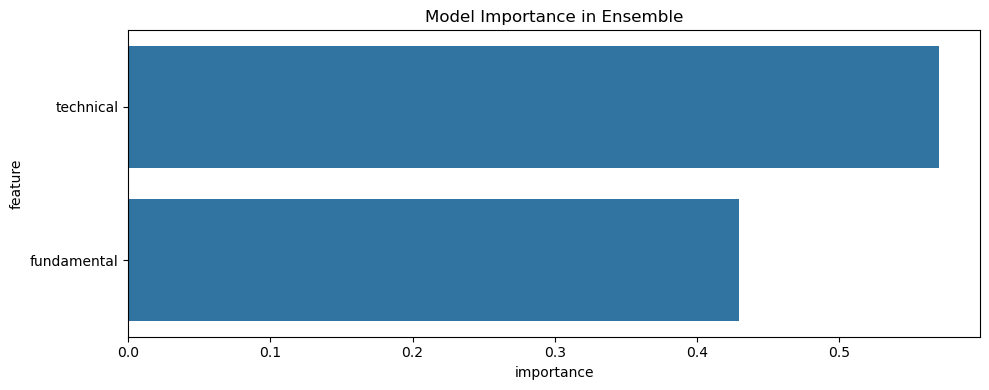

In [6]:
# 5. Feature importance
# 5. Feature importance
print("\nPlotting feature importance...")

# For StackingRegressor, we need to get feature importances differently
if hasattr(ensemble.final_estimator_, 'feature_importances_'):
    # Get the names of the base models
    model_names = [name for name, _ in ensemble.estimators]
    
    # Create DataFrame with model importance
    feature_importance = pd.DataFrame({
        'feature': model_names,
        'importance': ensemble.final_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Model Importance in Ensemble')
    plt.tight_layout()
    plt.savefig(f"../data/results/metrics/{ticker}_feature_importance.png")
    plt.show()
else:
    print("Final estimator doesn't have feature importances. Using coefficients instead.")
    
    if hasattr(ensemble.final_estimator_, 'coef_'):
        model_names = [name for name, _ in ensemble.estimators]
        feature_importance = pd.DataFrame({
            'feature': model_names,
            'importance': np.abs(ensemble.final_estimator_.coef_)
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 4))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title('Model Coefficients in Ensemble')
        plt.tight_layout()
        plt.savefig(f"../data/results/metrics/{ticker}_feature_importance.png")
        plt.show()
    else:
        print("Cannot compute feature importance - final estimator doesn't support it")

In [7]:
# 6. Prediction validation
print("\nValidating predictions...")
def check_predictions(model, X, y_true, model_type):
    preds = model.predict(X)
    print(f"\n{model_type} Model Predictions:")
    print(f"Predictions - Min: {preds.min():.4f}, Max: {preds.max():.4f}, Mean: {preds.mean():.4f}")
    print(f"Actual - Min: {y_true.min():.4f}, Max: {y_true.max():.4f}, Mean: {y_true.mean():.4f}")
    assert not np.isnan(preds).any()

check_predictions(tech_model, data['X_tech_test'][:100], data['y_test'][:100], "Technical")
check_predictions(ensemble, X_combined_test[:100], data['y_test'][:100], "Ensemble")

print("\nTraining pipeline completed successfully!")


Validating predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Technical Model Predictions:
Predictions - Min: -1.0804, Max: 0.4684, Mean: 0.0110
Actual - Min: -0.0564, Max: 0.0543, Mean: 0.0022
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Ensemble Model Predictions:
Predictions - Min: -0.0572, Max: 0.0524, Mean: 0.0128
Actual - Min: -0.0564, Max: 0.0543, Mean: 0.0022

Training pipeline completed successfully!
